In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

2023-11-15 15:09:51.314279: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 15:09:51.412052: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 15:09:51.412727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 15:09:52.114228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATA_PATH = 'imgs_zip/imgs/train/'
VALIDATION_PATH = 'imgs_zip/imgs/validation/'
TEST_PATH = 'imgs_zip/imgs/test/'

In [5]:
# Load the pre-trained model
base_model = EfficientNetB7(include_top=False, weights='imagenet')

# Fine-tune the pre-trained model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Create a data augmentation pipeline
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

# Define the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES),
    tf.keras.layers.Softmax()
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-5
)

# Train the model
history = model.fit_generator(
    train_datagen.flow_from_directory(DATA_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'),
    epochs=10,
    validation_data=validation_datagen.flow_from_directory(VALIDATION_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'),
    callbacks=[reduce_lr]
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_loss, test_accuracy = model.evaluate_generator(
    test_datagen.flow_from_directory(TEST_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Found 2497 images belonging to 15 classes.
Found 206 images belonging to 15 classes.


/tmp/ipykernel_27942/572468475.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10


2023-11-15 15:07:57.340249: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2023-11-15 15:07:57.424230: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2023-11-15 15:07:57.573703: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2023-11-15 15:07:57.637110: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2023-11-15 15:07:57.685199: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.


 1/79 [..............................] - ETA: 36:11 - loss: 2.7055 - accuracy: 0.0312

/home/sanarip03/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 8/79 [==>...........................] - ETA: 13:58 - loss: 2.7847 - accuracy: 0.0820

KeyboardInterrupt: 

In [5]:
base_model = EfficientNetB7(include_top=False, weights='imagenet')

for layer in base_model.layers[:-10]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(NUM_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Softmax()
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create a data augmentation pipeline
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-5
)

# Define a checkpoint callback to save the best model
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit_generator(
    train_datagen.flow_from_directory(DATA_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'),
    epochs=20,
    validation_data=validation_datagen.flow_from_directory(VALIDATION_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'),
    callbacks=[reduce_lr, checkpoint]
)

model = tf.keras.models.load_model('best_model.h5')

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_loss, test_accuracy = model.evaluate_generator(
    test_datagen.flow_from_directory(TEST_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Found 2497 images belonging to 15 classes.
Found 206 images belonging to 15 classes.


/tmp/ipykernel_28249/2742062514.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20


2023-11-15 15:11:32.465290: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.
2023-11-15 15:11:32.565214: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.
2023-11-15 15:11:32.843275: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 992894976 exceeds 10% of free system memory.


 1/79 [..............................] - ETA: 34:44 - loss: 4.2190 - accuracy: 0.0312

2023-11-15 15:11:44.181060: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.
2023-11-15 15:11:44.280956: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


 4/79 [>.............................] - ETA: 14:30 - loss: 4.1964 - accuracy: 0.0625

/home/sanarip03/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/79 [=====>........................] - ETA: 12:16 - loss: 4.0756 - accuracy: 0.0938

KeyboardInterrupt: 

In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
model = load_model('best_model.h5')

# Load the sample images
sample_images = []
for image_path in ['image1.jpg', 'image2.jpg', 'image3.jpg']:
    sample_image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
    sample_image = np.expand_dims(sample_image, axis=0)
    sample_images.append(sample_image)

# Make predictions on the sample images
predictions = model.predict(sample_images)

# Print the predictions
for prediction in predictions:
    print(prediction)

FileNotFoundError: [Errno 2] No such file or directory: 'image1.jpg'

In [4]:
# DATA_PATH = 'imgs_zip/imgs/train/'
BATCH_SIZE = 32
IMG_SIZE = (400, 400)
NUM_CLASSES = len(next(os.walk(DATA_PATH))[1])

In [8]:
train_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    'imgs_zip/imgs/validation/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1946 images belonging to 15 classes.
Found 206 images belonging to 15 classes.


In [5]:
# Define the model
base_model = Xception(include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES),
    layers.Softmax()
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=25, validation_data=validation_generator)

# Evaluate the model on the test set
test_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    'imgs_zip/imgs/test/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_generator)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/25


2023-11-09 16:36:27.399369: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40310784 exceeds 10% of free system memory.
2023-11-09 16:36:29.217121: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40310784 exceeds 10% of free system memory.
2023-11-09 16:36:29.230969: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 106172416 exceeds 10% of free system memory.
2023-11-09 16:36:29.293758: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 207101952 exceeds 10% of free system memory.
2023-11-09 16:36:29.366110: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 207101952 exceeds 10% of free system memory.


 4/37 [==>...........................] - ETA: 1:00 - loss: 2.6515 - accuracy: 0.1562

/home/sanarip03/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


37/37 [==============================] - 83s 2s/step - loss: 2.2282 - accuracy: 0.3118 - val_loss: 2.9506 - val_accuracy: 0.1699
Epoch 2/25
37/37 [==============================] - 77s 2s/step - loss: 1.7280 - accuracy: 0.4488 - val_loss: 2.9853 - val_accuracy: 0.1602
Epoch 3/25
37/37 [==============================] - 76s 2s/step - loss: 1.5117 - accuracy: 0.5177 - val_loss: 3.3020 - val_accuracy: 0.1650
Epoch 4/25
37/37 [==============================] - 76s 2s/step - loss: 1.3202 - accuracy: 0.5805 - val_loss: 3.4625 - val_accuracy: 0.1845
Epoch 5/25
37/37 [==============================] - 76s 2s/step - loss: 1.2264 - accuracy: 0.6176 - val_loss: 3.1846 - val_accuracy: 0.1845
Epoch 6/25
37/37 [==============================] - 76s 2s/step - loss: 1.1159 - accuracy: 0.6400 - val_loss: 3.1448 - val_accuracy: 0.2136
Epoch 7/25
37/37 [==============================] - 77s 2s/step - loss: 0.9996 - accuracy: 0.6873 - val_loss: 3.4973 - val_accuracy: 0.1990
Epoch 8/25
37/37 [=============

In [5]:
model.save('car_brands_model_v6.h5')

/home/sanarip03/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('Tea-Leaf-Disease-Detection-main/notebooks/vgg16_upd.h5')

In [9]:
img = image.load_img('test.jpeg', target_size=IMG_SIZE)

img_array = image.img_to_array(img) / 255.

img_batch = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_batch)

predicted_class = np.argmax(predictions[0])

class_names = list(train_generator.class_indices.keys())
predicted_class_name = class_names[predicted_class]

print(f"Predicted class label: {predicted_class}")
print(f"Predicted class name: {predicted_class_name}")

ValueError: in user code:

    File "/home/sanarip03/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/sanarip03/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/sanarip03/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/sanarip03/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/sanarip03/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/sanarip03/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 400, 400, 3)


In [15]:
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import resize

# Load your image
img = load_img('kok.jpg')  # replace with your image path
img_array = img_to_array(img) / 255.  # Normalize the image

# Resize the image to match the input shape of the model
resized_img = resize(img_array, [224, 224])

# Expand the dimensions to match the model's input format
img_batch = np.expand_dims(resized_img, axis=0)

# Now make the prediction
predictions = model.predict(img_batch)

print(predicted_class_name)

1/1 [==============================] - 0s 76ms/step
Chevrolet


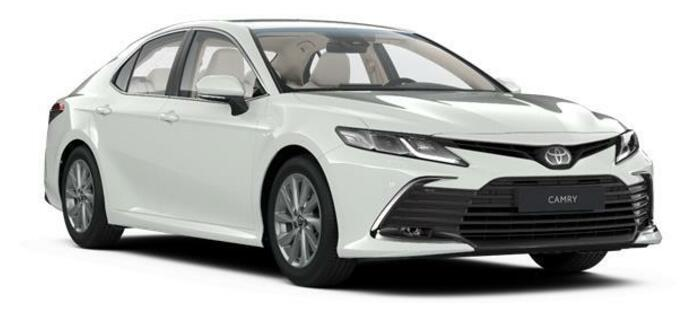

In [14]:
img

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
# Load the dataset
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    'train_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=5)

# Evaluate the model
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    'validation_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_loss, validation_accuracy = model.evaluate(validation_generator)

Found 1721 images belonging to 6 classes.
Epoch 1/5
54/54 [==============================] - 30s 533ms/step - loss: 0.8873 - accuracy: 0.7954
Epoch 2/5
54/54 [==============================] - 29s 533ms/step - loss: 0.4558 - accuracy: 0.8333
Epoch 3/5
54/54 [==============================] - 29s 536ms/step - loss: 0.4522 - accuracy: 0.8333
Epoch 4/5
54/54 [==============================] - 29s 536ms/step - loss: 0.4514 - accuracy: 0.8333
Epoch 5/5
54/54 [==============================] - 29s 537ms/step - loss: 0.4510 - accuracy: 0.8333
Found 283 images belonging to 6 classes.
9/9 [==============================] - 2s 169ms/step - loss: 0.4512 - accuracy: 0.8333


In [ ]:
model.save('car_logo_highlighting_model.h5')

In [ ]:
# model.save('car_logo_highlighting_model.h5')

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('car_logo_highlighting_model.h5')

In [ ]:
img = image.load_img('kok.jpg', target_size=IMG_SIZE)

img_array = image.img_to_array(img) / 255.

img_batch = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_batch)

# Index into the predictions tensor to get the prediction for the current image
predicted_class_prediction = predictions[0][predicted_class]

# Get the predicted class label
predicted_class_label = np.argmax(predicted_class_prediction)

class_names = list(train_generator.class_indices.keys())
predicted_class_name = class_names[predicted_class_label]

print(f"Predicted class label: {predicted_class_label}")
print(f"Predicted class name: {predicted_class_name}")

1/1 [==============================] - 0s 20ms/step
Predicted class label: 0
Predicted class name: lexus


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="N86kckLhQw2GVSpECba9")
project = rf.workspace().project("cars-logo-my5mz")
model = project.version(2).model

# infer on a local image
print(model.predict("kok.jpg", confidence=3, overlap=99).json())

# visualize your prediction
# model.predict("your_image.jpg", confidence=40, overlap=30).save("prediction.jpg")

# infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE", hosted=True, confidence=40, overlap=30).json())

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [], 'image': {'width': '700', 'height': '316'}}


In [ ]:
import cv2
import numpy as np

def align_channels(img, reference_channel=2):
    """Align channels of an RGB image.
    
    Parameters:
    - img: Input RGB image
    - reference_channel: Channel index to use as reference for alignment (default is 2 for blue channel)
    
    Returns:
    - Aligned RGB image
    """
    
    channels = cv2.split(img)
    
    aligned_channels = []
    for i, channel in enumerate(channels):
        if i == reference_channel:
            aligned_channels.append(channel)
            continue

        shift = cv2.phaseCorrelate(channels[reference_channel].astype(np.float32), channel.astype(np.float32))[0]

        M = np.float32([[1, 0, shift[0]], [0, 1, shift[1]]])
        aligned_channel = cv2.warpAffine(channel, M, (img.shape[1], img.shape[0]))

        aligned_channels.append(aligned_channel)from tensorflow.keras.applications import EfficientNetB7
    
    aligned_img = cv2.merge(aligned_channels)
    return aligned_img

img = cv2.imread('/home/sanarip03/Desktop/бренд_машин/vancouver_tableau.jpg')

aligned_img = align_channels(img)

cv2.imwrite('aligned_image.jpg', aligned_img)


True

In [ ]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import cv2

def detect_car(image_path):
    car_cascade = cv2.CascadeClassifier('cars.xml')

    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    cars = car_cascade.detectMultiScale(gray, 1.1, 2)

    for (x, y, w, h) in cars:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    cv2.imshow('Detected Cars', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

image_path = 'test.jpeg'
detect_car(image_path)


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/sanarip03/.local/lib/python3.10/site-packages/cv2/qt/plugins"


In [ ]:
from PIL import Image
import cv2
import numpy as np
import requests  

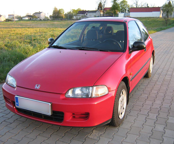

In [ ]:
# Reading image form url
image = Image.open(requests.get('https://upload.wikimedia.org/wikipedia/commons/2/20/Honda_Civic_1995.jpg', stream=True).raw)
image = image.resize((174,144))
image_arr = np.array(image)
image

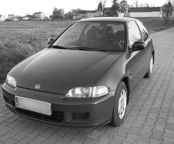

In [ ]:
grey = cv2.cvtColor(image_arr,cv2.COLOR_BGR2GRAY)
Image.fromarray(grey)

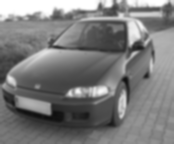

In [ ]:
blur = cv2.GaussianBlur(grey,(5,5),0)
Image.fromarray(blur)

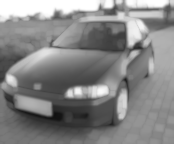

In [ ]:
dilated = cv2.dilate(blur,np.ones((3,3)))
Image.fromarray(dilated)

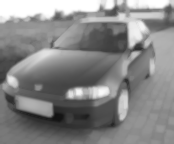

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel) 
Image.fromarray(closing)

In [ ]:
car_cascade_src = 'cars.xml'
car_cascade = cv2.CascadeClassifier(car_cascade_src)
cars = car_cascade.detectMultiScale(closing, 1.1, 1)

1  cars found


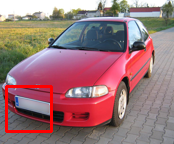

In [ ]:
cnt = 0
for (x,y,w,h) in cars:
  cv2.rectangle(image_arr,(x,y),(x+w,y+h),(255,0,0),2)
  cnt += 1
print(cnt, " cars found")
Image.fromarray(image_arr)

In [ ]:
import cv2
import numpy as np

In [ ]:
# Load the YOLOv5s configuration file
model = cv2.dnn.readNetFromDarknet('/home/sanarip03/Desktop/бренд_машин/yolov5/models/segment/yolov5s-seg.yaml', '/home/sanarip03/Desktop/yolov5/models/yolov5s.weights')

# Load the car image
image = cv2.imread('kok.jpg')

# Run the object detection model on the car image
detections = model.detect(image)

# Identify the bounding box for the car logo
car_logo_bbox = None
for detection in detections:
    class_id = detection[6]
    if class_id == 67:  # Car logo class ID in COCO dataset
        car_logo_bbox = detection[0:4]

# Highlight the car logo
cv2.rectangle(image, (car_logo_bbox[0], car_logo_bbox[1]), (car_logo_bbox[2], car_logo_bbox[3]), (0, 0, 255), 2)

# Display the highlighted car image
cv2.imshow('Image', image)
cv2.waitKey(0)

error: OpenCV(4.8.0) /io/opencv/modules/dnn/src/darknet/darknet_importer.cpp:217: error: (-212:Parsing error) Failed to parse NetParameter file: /home/sanarip03/Desktop/yolov5/models/yolov5s.weights in function 'readNetFromDarknet'


In [ ]:
import wget

In [ ]:
wget.download('https://github.com/ultralytics/yolov5/releases/download/v6.2/yolov5s.weights')

HTTPError: HTTP Error 404: Not Found